In [13]:
# Verified!
import torch
import numpy as np
import os

data_dir = './fwdnet/gen_20241111/preprocessed/'
nk_dir = './fwdnet/nk_data/241024/interpolated-npy/'
fwd_path = "./fwdnet/net/241112/LSTM_Txy_lr_0.001894291444441104_bsize_500_init_X_N_fc_feature_layer_100_300_500_500_500_hidden_size_500_nlayer_3/MSE=0.000735.pt"

# Trained
bidx = 4-1
trainf = './test_1224_result/3000.pt'
train_result = torch.load(trainf)
h = train_result[f'H_{bidx}']
p = train_result[f'P_{bidx}']
lw = train_result[f'LW_{bidx}'].numpy()
lw = np.expand_dims(lw, 1)
numP = train_result[f'NumP_{bidx}'].numpy() + 1
rot = train_result[f'Rot_{bidx}'].numpy()
nk_idx = int(train_result[f'nk_idx_{bidx}'])
nk_list = os.listdir(nk_dir)
nk_list.sort()
nk_f = nk_list[nk_idx]

# # Meta dictionary
# import pickle
# path_holo = './fwdnet/tri_hologram_450/metaatom_dictionaries/meta_dict_nk_T100P30h=880_p=400_ar-100_num-700.pkl'
# with open(path_holo, 'rb') as f:
#     fname = path_holo.split('/')[-1]
#     dict_meta = pickle.load(f)
# nk_f = path_holo.split('nk_')[1].split('h=')[0] + '.npy'
# h = np.array(int(fname.split('h=')[1][:3])); p=np.array(int(fname.split('p=')[1][:3]))
# lwn = dict_meta['LWN']
# unitcell_indicator = dict_meta['unitcell_indicator']
# rotation_indicator = dict_meta['rotation_indicator']
# lwn_2d = lwn[unitcell_indicator]
# lwn_flat = lwn_2d.reshape(-1, 3)
# lw = np.expand_dims(np.int32(lwn_flat[:, 0:2]), 1)
# numP = lwn_flat[:, 2]
# rot = rotation_indicator

numP_unnorm = numP.reshape(-1, 1, 1)
h_unnorm = np.array(h).repeat(lw.shape[0]).reshape(-1, 1, 1)
p_unnorm = np.array(p).repeat(lw.shape[0]).reshape(-1, 1, 1)
lw_unnorm = lw
geom_unnorm = np.concatenate((numP_unnorm, h_unnorm, p_unnorm, lw_unnorm), axis=2)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(1, '/home/linkle115/vscode_server/EEasih')
from fwdnet.jbnet import *

def norm(unnorm_tensor, data_dir, target, device):
    unnorm_tensor = unnorm_tensor.to(dtype=torch.float32, device=device)
    mean = torch.load(data_dir + target + '_mean.pt').to(dtype=torch.float32, device=device)
    std = torch.load(data_dir + target + '_std.pt').to(dtype=torch.float32, device=device)
    norm_tensor = (unnorm_tensor - mean) / (std + 1e-10)
    return norm_tensor

class UniqueWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A):
        # Use numpy to find unique rows, but we'll also need to track which rows were selected
        unique, inverse_indices = torch.unique(A, dim=0, return_inverse=True)
        ctx.save_for_backward(inverse_indices, torch.tensor(A.shape, device=A.device))
        return unique, inverse_indices

    @staticmethod
    def backward(ctx, grad_unique, grad_inverse_indices):
        inverse_indices, original_shape = ctx.saved_tensors
                
        # Expand grad_unique to match the dimensions of the input tensor
        grad_expanded = grad_unique[inverse_indices]

        return grad_expanded, None

def unique_with_grad(A):
    return UniqueWithGrad.apply(A)

def run_extract(fwd_input, net, numX, device):
    def c_intp_mag(x1, x2, x_mid, y1, y2):
        return y1 + (y2 - y1) / (x2 - x1) * (x_mid - x1)
             
    def c_intp_phase(x1, x2, x_mid, ar_y1, ar_y2):
        y_mid = torch.zeros_like(ar_y1, device=device)
        for i, (y1, y2) in enumerate(zip(ar_y1, ar_y2)):
            if y1 * y2 >= 0:
                y_mid[i] = y1 + (y2 - y1) / (x2 - x1) * (x_mid - x1)
            elif y1 < y2: # y1 < 0 < y2
                y_minus = y1 + 2; y_plus = y2; x_minus = x1; x_plus = x2
                y_mid[i] =  y_minus + (y_plus - y_minus) / (x_plus - x_minus) * (x_mid - x_minus)
            elif y2 < y1: # y2 < 0 < y1
                y_minus = y2 + 2; y_plus = y1; x_minus = x2; x_plus = x1
                y_mid[i] =  y_minus + (y_plus - y_minus) / (x_plus - x_minus) * (x_mid - x_minus)
        y_mid[y_mid > 1] -= 2
        return y_mid 
    
    def txy_to_tmp(tx, ty):
        tm = tx ** 2 + ty ** 2
        epsilon = 1e-10
        safe_tx = tx + epsilon * torch.sign(tx)
        tp = torch.atan(ty / (safe_tx)) / torch.pi \
        - torch.logical_and(tx < 0, ty < 0).type(torch.float32) \
        + torch.logical_and(tx < 0, ty > 0).type(torch.float32)
        return tm, tp
    
    wl = [450, 532, 635]
    num_wl = len(wl)

    u_fwd_input, inverse_indices = unique_with_grad(fwd_input)
    u_fwd_output = net(u_fwd_input)
    u_tm = torch.zeros([u_fwd_output.shape[0], num_wl], device=device)
    u_tp = torch.zeros([u_fwd_output.shape[0], num_wl], device=device)
    for i in range(num_wl):
        x_i1 = (wl[i] // 10) * 10; x_i2 = x_i1 + 10
        idx_i1 = (x_i1 - 400) // 10; idx_i2 = idx_i1 + 1
        tm_i1, tp_i1 = txy_to_tmp(u_fwd_output[:, idx_i1, 0], u_fwd_output[:, idx_i1, 1])
        tm_i2, tp_i2 = txy_to_tmp(u_fwd_output[:, idx_i2, 0], u_fwd_output[:, idx_i2, 1])
        u_tm[:, i] = c_intp_mag(x_i1, x_i2, wl[i], tm_i1, tm_i2)
        u_tp[:, i] = c_intp_phase(x_i1, x_i2, wl[i], tp_i1, tp_i2)
    
    # Map u_tm to tm
    tm = u_tm[inverse_indices]
    tp = u_tp[inverse_indices]
    tm_reshaped     = tm.view(numX, numX, num_wl)
    tp_reshaped     = tp.view(numX, numX, num_wl)
    return tm_reshaped, tp_reshaped

nk_selected = torch.from_numpy(np.load(nk_dir + nk_f))

# device
device = torch.device('cuda')

# Elongate the input
nk_elong = torch.tile(nk_selected, dims=(geom_unnorm.shape[0], 1, 1))
geom_elong = torch.tile(torch.from_numpy(geom_unnorm), dims=(1, 31, 1))

# Normalize the input
nk_norm = norm(nk_elong, data_dir, 'NK', device)
geom_norm = norm(geom_elong, data_dir, 'Geom', device)
fwd_input = torch.concat([nk_norm, geom_norm], dim=2)


# Load the trained model
checkpoint = torch.load(fwd_path) 
fwdnet_file = fwd_path.split('/')[-2]
init = fwdnet_file.split('init_')[1][:3]   
hs = int(fwdnet_file.split('hidden_size_')[1].split('_nlayer')[0])
channels = [int(i) for i in fwdnet_file.split('fc_feature_layer_')[1].split('_hidden_size')[0].split('_')]
nl = int(fwdnet_file.split('_nlayer_')[1])
fc_layers = [{'in_channels': channels[i], 'out_channels': channels[i+1]} for i in range(len(channels)-1)]
model_args = {'init': init,
              'input_size': 7,
              'hidden_size': hs,
              'num_layer': nl,
              'fc_feature_layer': fc_layers}
net = LSTM(**model_args, device=device)
if fwd_path.find("TxyR") == -1:
    net.build_fc_layer(input_dim=7, output_dim=2)
else:
    net.build_fc_layer(input_dim=7, output_dim=3)
net.load_state_dict(checkpoint['network'])
net.to(device)
net.eval()

tm, tp = run_extract(fwd_input, net, 700, device)
tm_np = tm.cpu().detach().numpy()
tp_np = tp.cpu().detach().numpy() * np.pi + rot.reshape(700, 700, 1) * (2 * np.pi / 6)

Conversion efficiency of SiNx_mid.npy
B: 74.01%, G: 60.23%, R: 44.99%
Norm loss: 1.4646335211331438


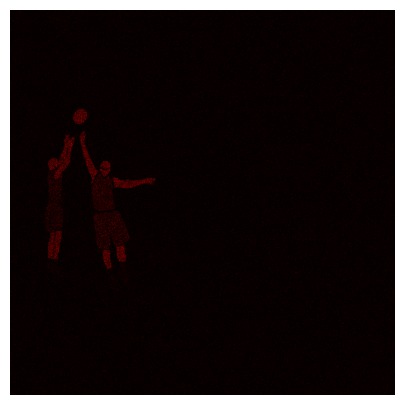

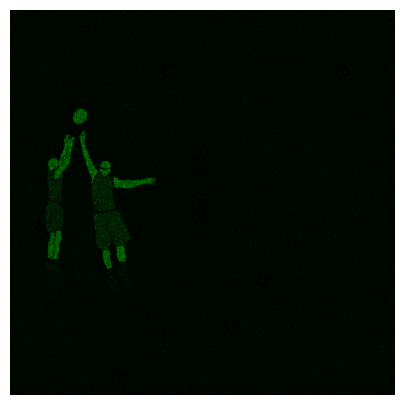

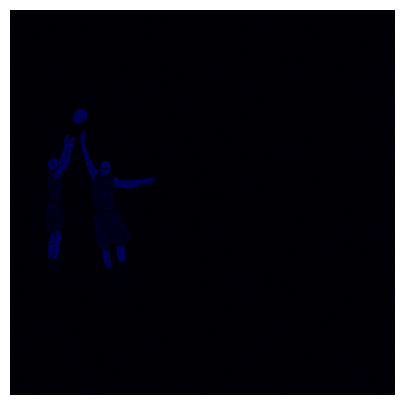

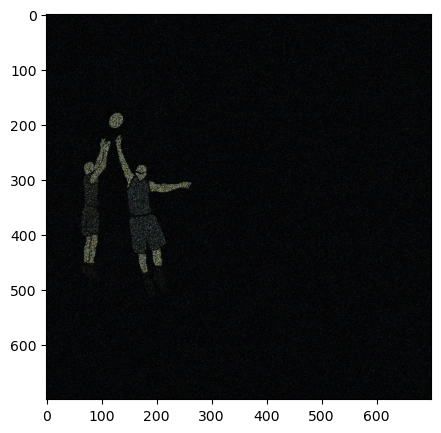

In [15]:
def visualize_hologram(phase, mag):
    # hologram visualization
    I_rgb = np.zeros((phase.shape[0], phase.shape[1], 3))
    for i in range(3):        
        phase_i = phase[:,:,i]
        mag_i = mag[:,:,i]
        efield = mag_i * np.exp(1j * phase_i)
        # Simulation of hologram image using GS algorithm
        I_test = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(efield)))  # forward propagation
        out = np.abs(I_test) ** 2
        num = I_test.shape[1] 
        idx_center = [i for i in range(num) if (abs(i-num//2) < 2)]
        out[idx_center[0] : idx_center[-1]+1, idx_center[0]: idx_center[-1]+1] = 0
        out_norm = out / np.max(out)  # normalization
        I_rgb[:, :, i] = out_norm
        
    # Conversion efficiency
    c_eff = np.mean(mag, axis=(0, 1))
    print(f'Conversion efficiency of {nk_f}')
    print(f'B: {100 * c_eff[0]:.2f}%, G: {100 * c_eff[1]:.2f}%, R: {100 * c_eff[2]:.2f}%')
    
    # Display holograms
    figsize=(5, 5)
    for i in range(3):
        fig, ax = plt.subplots(figsize=figsize)
        I_i = np.zeros_like(I_rgb)
        I_i[:, :, i] = I_rgb[:, :, 2-i]
        ax.axis('off')
        plt.imshow(I_i)
    fig, ax = plt.subplots(figsize=figsize)
    plt.imshow(I_rgb)
    
    return I_rgb

epsilon = 1e-8
tE = np.sqrt(tm_np * 1.45 + epsilon)
I = visualize_hologram(tp_np, tE)
    
def Norm_loss(I, I_tar, batch_weights, norm_weight):
    normloss = 0.0
    sum_batch_weight = sum(batch_weights)
    for i in range(3):
        I_i = I[:,:,i]
        target_i = I_tar[:,:,i]
        avg_target_i = np.mean(target_i)
        avg_I = np.mean(I_i)
        norm_I_i = avg_target_i * I_i / avg_I
        normloss += norm_weight * (batch_weights[i] / sum_batch_weight) * np.mean((norm_I_i - target_i) ** 2)
    return normloss

import cv2
from lens_distort import lensdistort
def gen_target_images(img_type, num_meta) -> None:
    img_dir = './source_image/'
    original_img = [img_type + '_' + c + '.png' for c in ['Blue', 'Green', 'Red']]
    img = np.zeros([num_meta, num_meta, 3])
    for i in range(3):
        f_img = original_img[i]
        I = cv2.imread(img_dir + f_img, cv2.IMREAD_GRAYSCALE)
        I = cv2.resize(I, (num_meta, num_meta))
        I = I / np.max(I)
        I = I[:, ::-1]
        
        clev = 0.6
        I = lensdistort(I,clev, ftype=3, bordertype='fit')    # "lensdistort" is a help function
        for idx1 in range(num_meta):
            for idx2 in range(num_meta):
                if idx1 < 40 or idx1 > (num_meta-40) or idx2 < 40 or idx2 > (num_meta-40):   # boundaries can be changed after checking "compensated_img"
                    I[idx1, idx2] = 0                 # removal of white edges
        I[I<0] = 0                              # removal of negative values
        I = I/np.max(I)                         # renormalization
        img[:, :, i] = I            # BGR to RGB
    return img

I_target = gen_target_images('Basketball', 700)
loss_norm = Norm_loss(I, I_target, [1.0, 1, 1.3], 100.0)
print(f'Norm loss: {loss_norm}')